In [1]:
import pandas as pd
import os
from pathlib import Path
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DL = ['DenseNet201', 'MobileNetV2', 'InceptionV3', "ResNet50"]
ML = ['GradientBoosting', 'KNN', 'NBayes', "RandomForest"]
COLUMNS = ["val_accuracy", "val_precision", "val_specificity", "val_f1_score", "val_auc", "val_sensitivity"]
SUBSETS = ['Dataset01_100', 'Dataset01_95.0', 'Dataset01_90.0', 'Dataset01_85.0', 'Dataset01_80.0', 'Dataset01_75.0', 
           'Dataset01_70.0', 'Dataset01_65.0', 'Dataset01_60.0', 'Dataset01_55.0', 'Dataset01_50.0', 'Dataset01_45.0',
           'Dataset01_40.0', 'Dataset01_35.0', 'Dataset01_30.0', 'Dataset01_25.0', 'Dataset01_20.0', 'Dataset01_15.0', 
           'Dataset01_10.0', 'Dataset01_5.0']


In [3]:
path_project = Path().absolute().parent.parent.parent
results_path = path_project / "6_resultados"

output = results_path / "analitycs" / "by_test"

In [4]:
import pandas as pd
import os
from pathlib import Path

# Define paths
path_project = Path().absolute().parent.parent.parent
results_path = path_project / "6_resultados"

# DataFrame to hold all results
all_results = []

# Process each network and subset
for network in DL + ML:
    for subset in SUBSETS:
        # Define the path for CSV files
        metrics_path = results_path / subset / network / "metrics"
        if network in DL:
            csvs_path = metrics_path / "csvs" / '_refined'
        else:
            csvs_path = metrics_path
        
        # List all files in the directory
        if csvs_path.exists() and csvs_path.is_dir():
            csv_files = [f for f in csvs_path.iterdir() if f.is_file()]
            
            # Read each file and append to the list
            for csv_file in csv_files:
                
                try:
                    df = pd.read_csv(csv_file)
                    
                    df['Model'] = network
                    df['Subset'] = subset
                    if str(csv_file).split("/")[-1].split(".")[0].endswith("f"):
                       df['dataset'] = df["dataset"].apply(lambda x: x.split("_")[1]).astype(float)
                    all_results.append(df)
                except Exception as e:
                    print(f"Error reading {csv_file}: {e}")



# Concatenate all DataFrames
result = pd.concat(all_results, ignore_index=True)
result.to_csv("all_results.csv", index=False)
result.head()



#drop nan in dataset column and how many nan we have


print(result['dataset'].unique())

[100.  95.  90.  85.  80.  75.  70.  65.  60.  55.  50.  45.  40.  35.
  30.  25.  20.  15.  10.   5.]


In [5]:
#  Análise estatística (teste de hipótese)
#  hipotese: quero provar que a variação das ROI's influencia no desempenho e métricas dos modelos de redes neurais
#  hipotese nula (H0): as métricas de desempenho dos modelos de redes neurais são iguais entre cada subconjunto de dados (SUBSETS -> ROIS)
#  hipotese alternativa (H1): as métricas de desempenho dos modelos de redes neurais são diferentes entre cada subconjunto de dados (SUBSETS -> ROIS)
# alpha = 0.01, 1% de significância, de concluir que a hipótese nula é falsa quando ela é verdadeira.
# Valor-p (p-value)
## Se p-value < alpha: rejeita-se a hipótese nula (temos evidências suficientes para rejeitar a hipótese nula) (0) (green)
## Se p-value >= alpha: não rejeita-se a hipótese nula (não temos evidências suficientes para rejeitar a hipótese nula) (1) (red)
# Teste de hipótese: ranksums (teste de Mann-Whitney)



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy.stats import ranksums
from matplotlib.colors import ListedColormap

# Função para testar a hipótese
def test_hyphotesis(main_pd, roi, alpha=0.01):
    normalized_values = pd.DataFrame()
    for network in main_pd['network'].unique():
        network_data = main_pd[main_pd['network'] == network]
        roi_data = network_data[network_data['dataset'] == roi]
       
        # Avaliando todas as métricas
        for column in COLUMNS:
            # Comparação com 100% de ROI
            p_value = ranksums(roi_data[column], network_data[network_data['dataset'] == 100][column], alternative='two-sided').pvalue
            h = 0 if p_value < alpha else 1
            normalized_values = normalized_values._append({'network': network, 'roi': roi, 'column': column, 'p_value': p_value, 'h': h}, ignore_index=True)
        
    return normalized_values

# Aplicação da função e geração do CSV
result_p_values = pd.DataFrame()
for roi in result['dataset'].unique():
    result_p_values = pd.concat([result_p_values, test_hyphotesis(result, roi)], ignore_index=True)

result_p_values.to_csv(output / "p_values.csv", index=False)




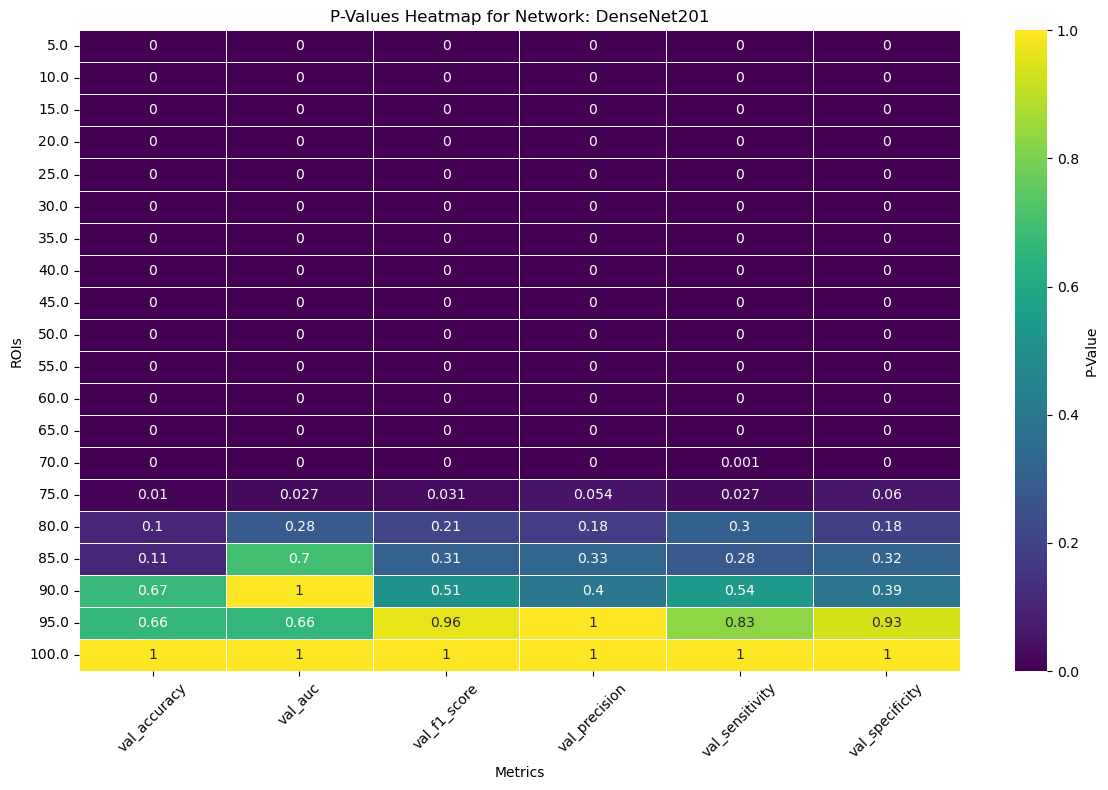

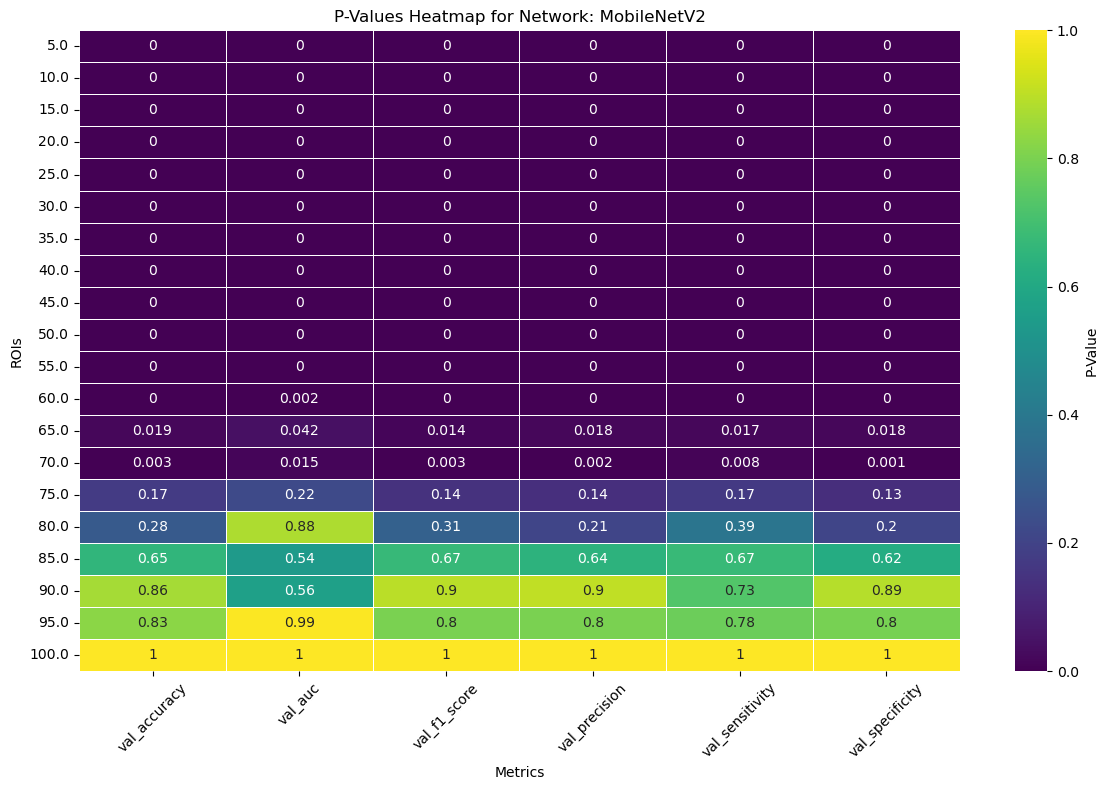

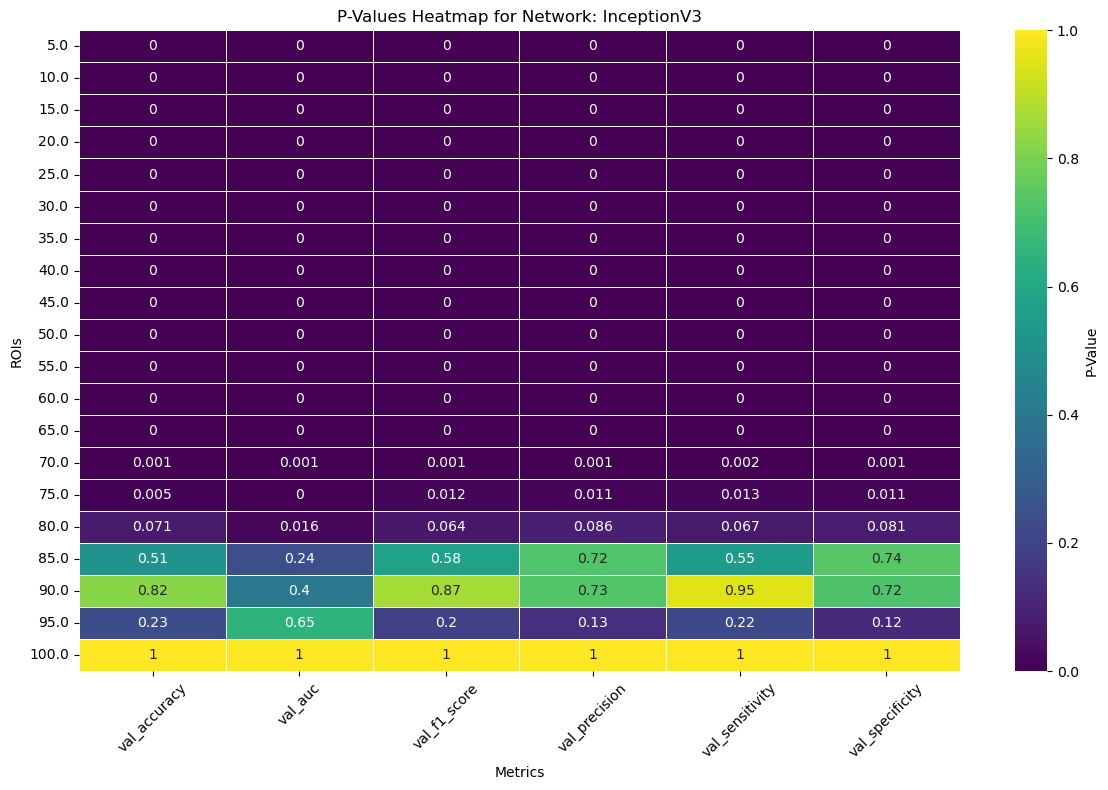

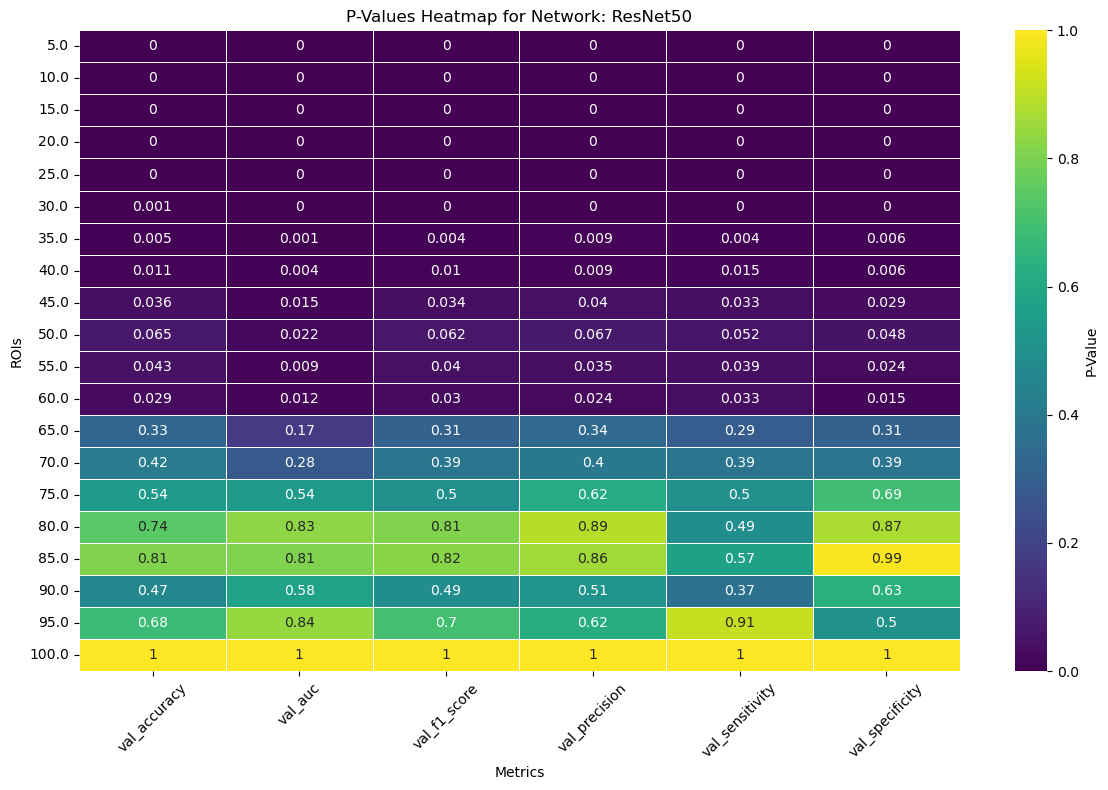

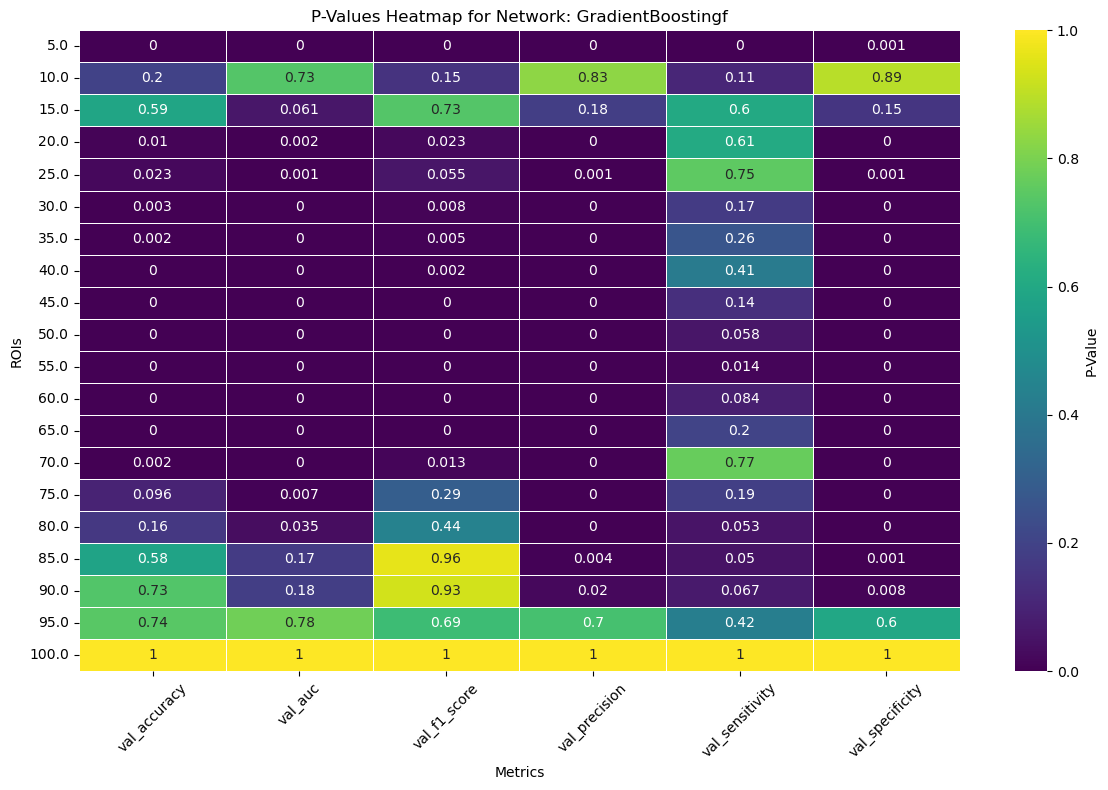

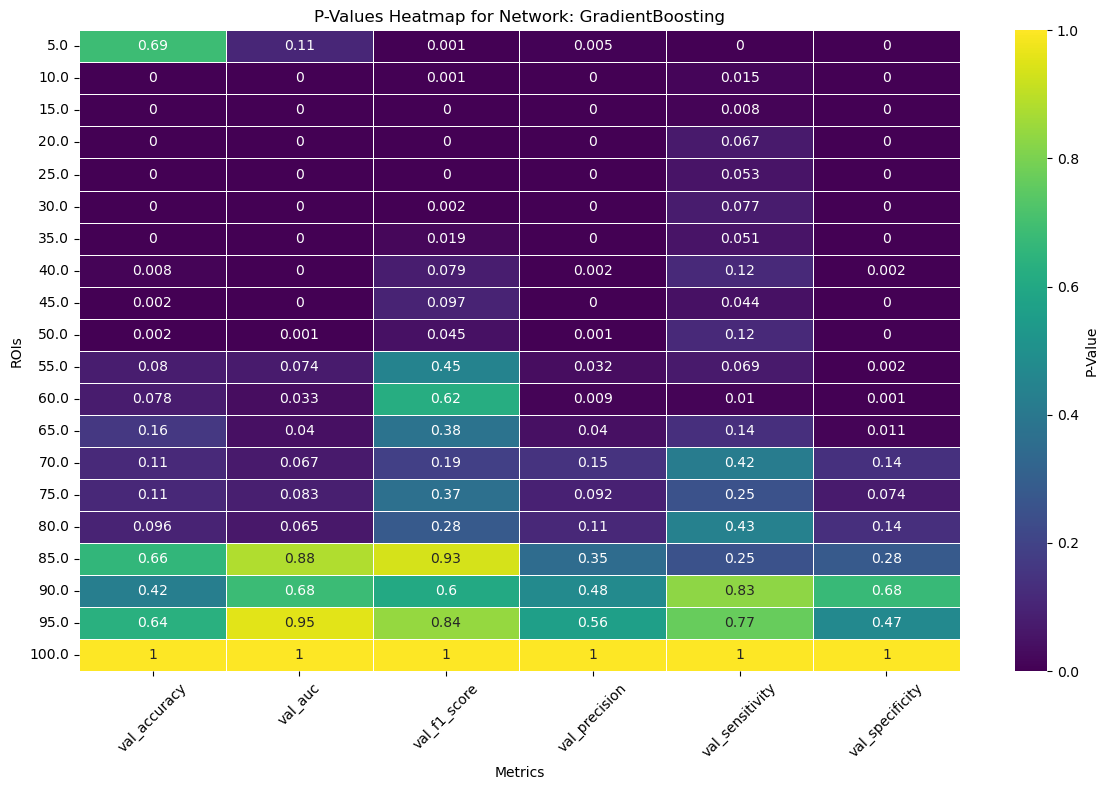

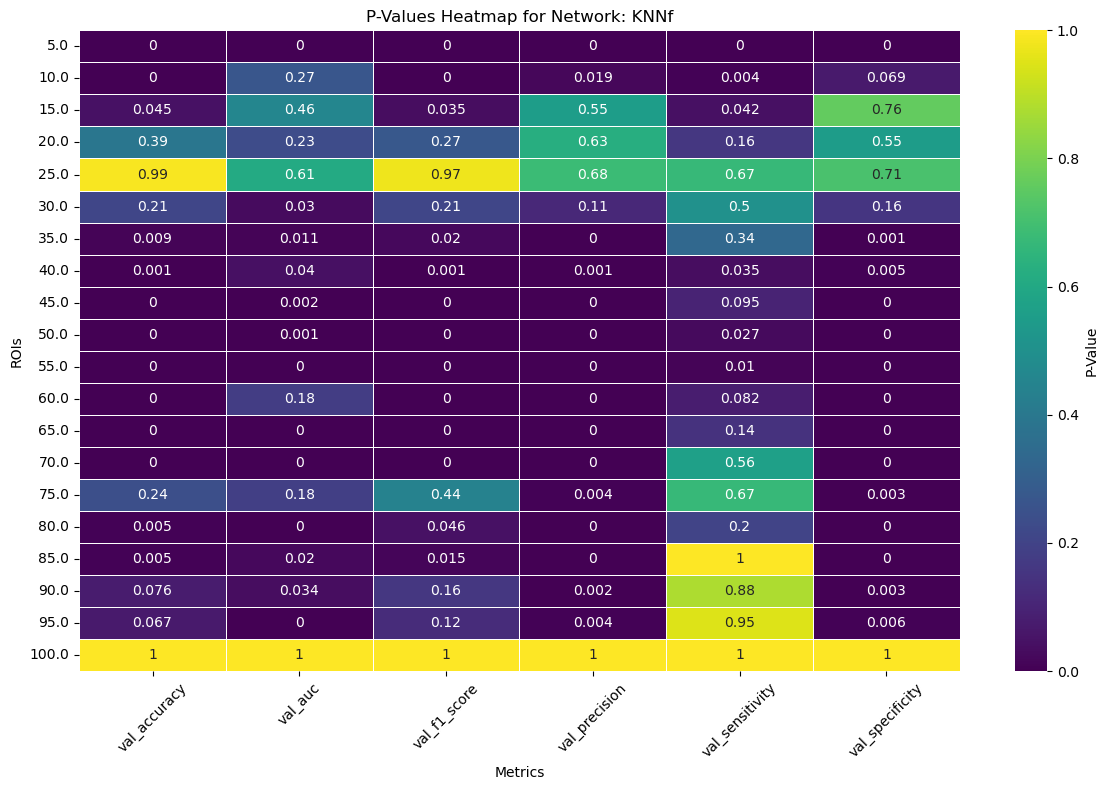

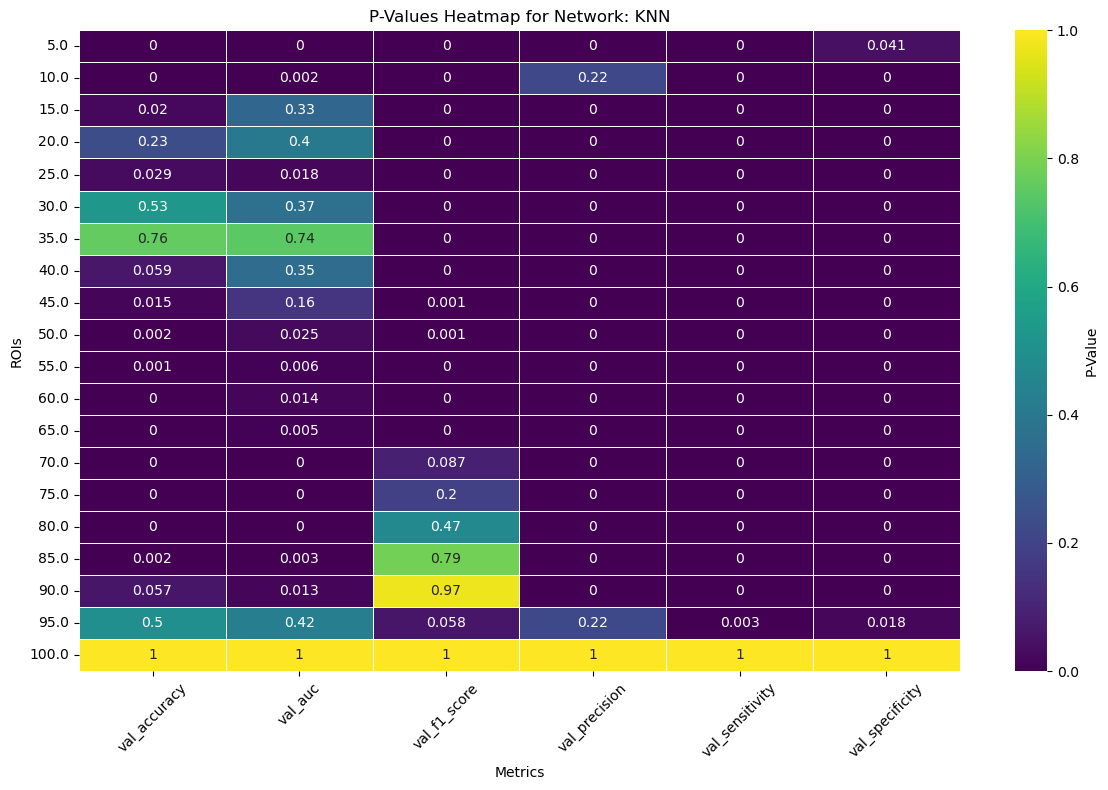

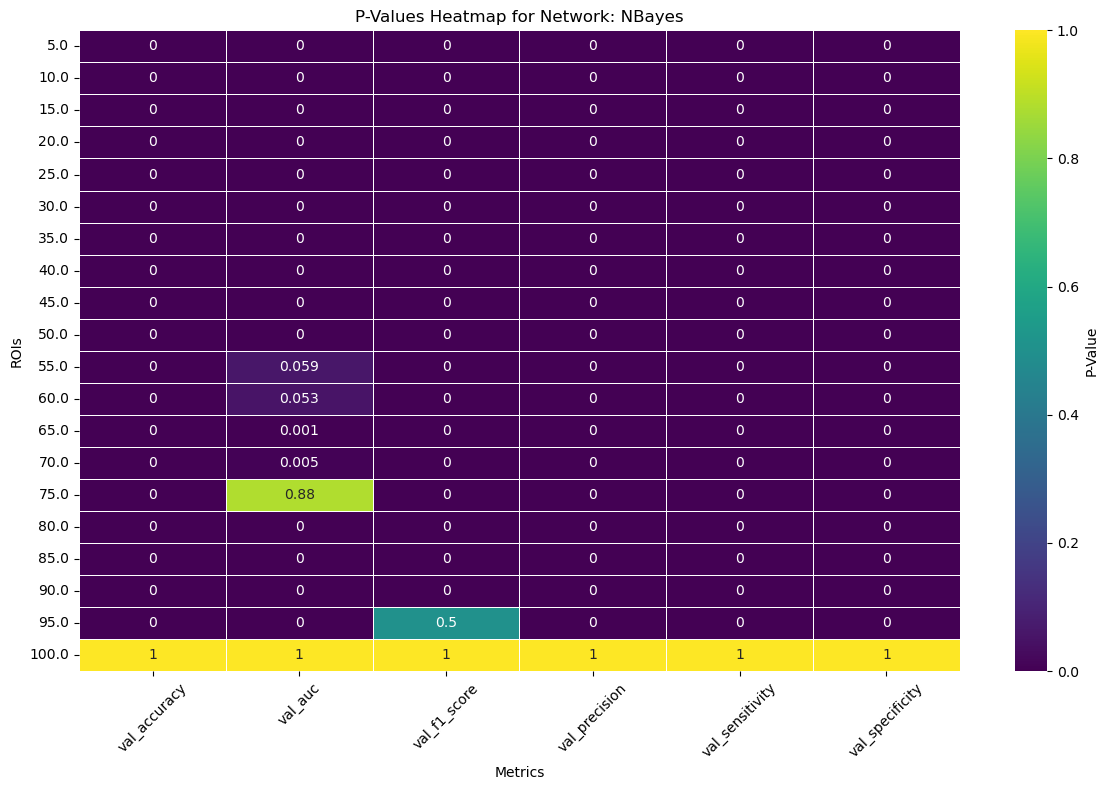

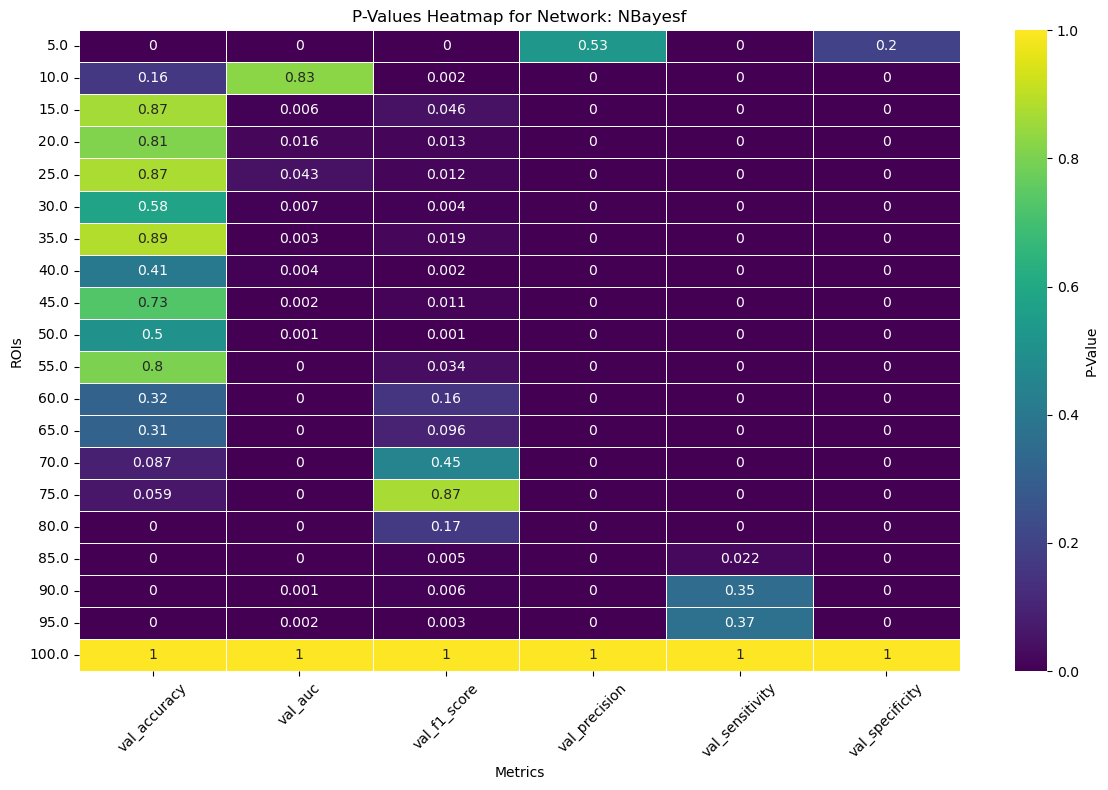

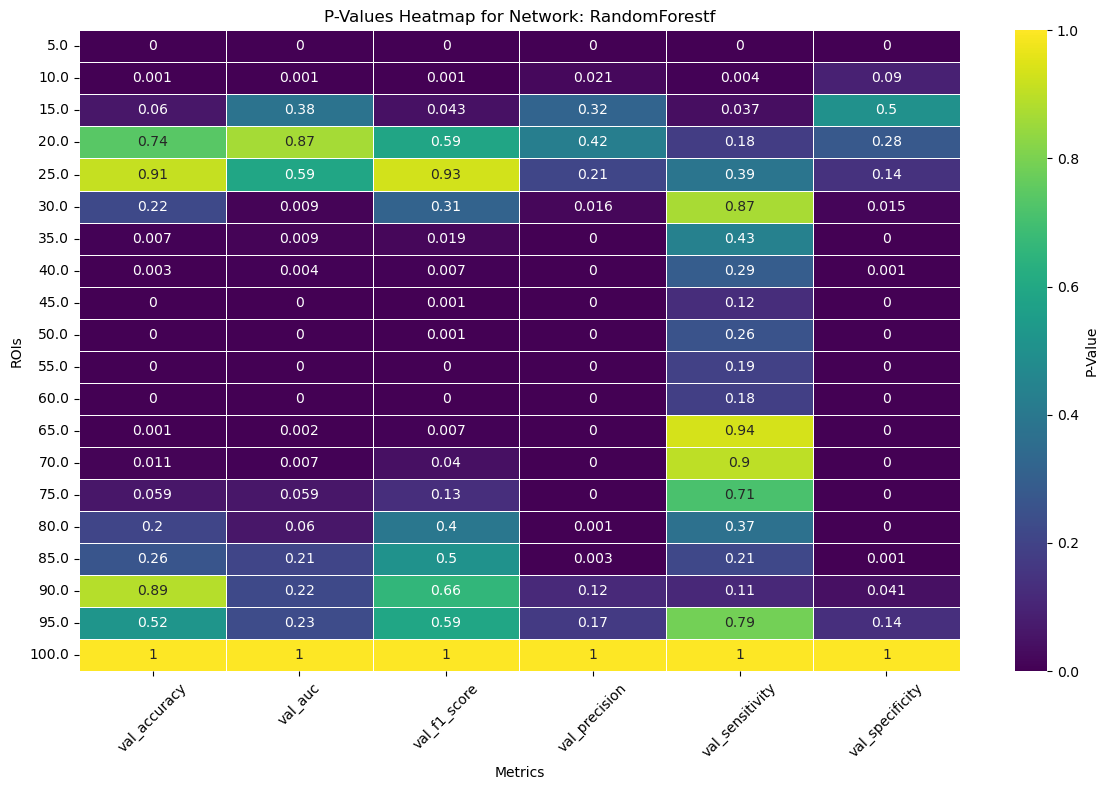

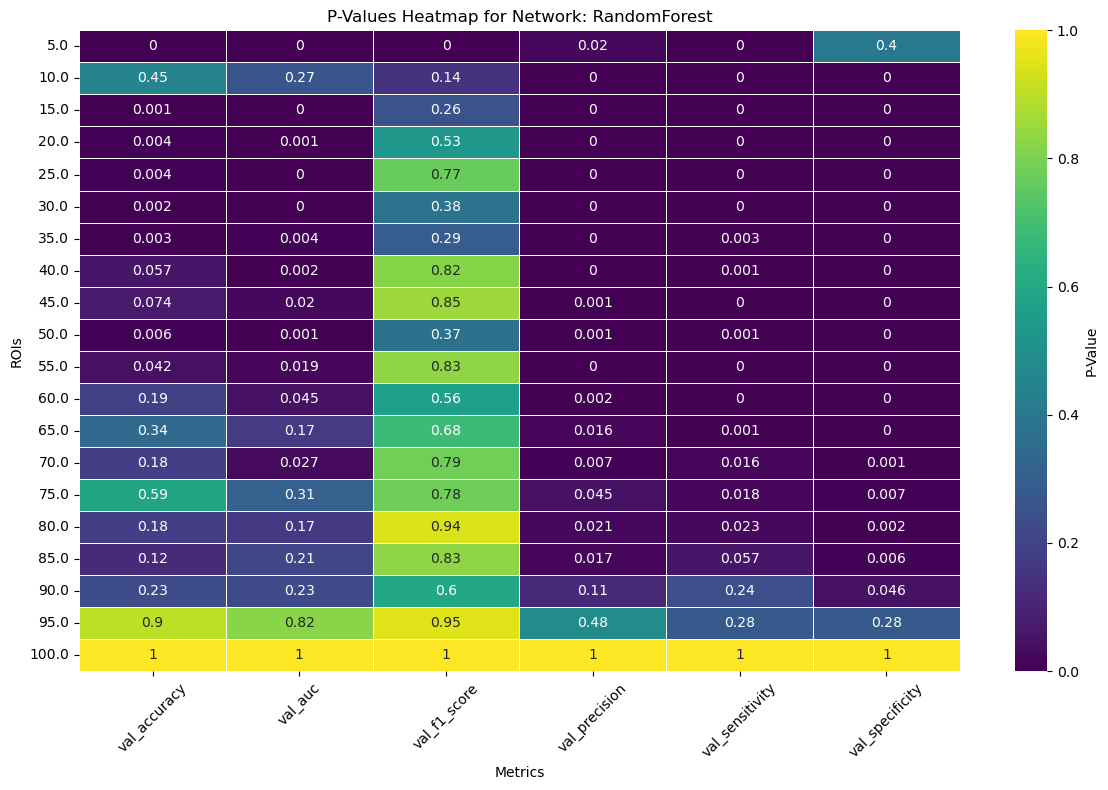

In [7]:

# Criando o heatmap para cada rede
unique_networks = result_p_values['network'].unique()
unique_rois = sorted(result_p_values['roi'].unique())
unique_columns = sorted(result_p_values['column'].unique())

# Gerar heatmap para cada rede
for network in unique_networks:
    # Filtrando os dados para a rede atual
    network_data = result_p_values[result_p_values['network'] == network]

    # Criando uma matriz de p-values
    heatmap_data = pd.DataFrame(index=unique_rois, columns=unique_columns)
    for roi in unique_rois:
        for column in unique_columns:
            p_value = network_data[(network_data['roi'] == roi) & (network_data['column'] == column)]['p_value']
            if not p_value.empty:
                heatmap_data.at[roi, column] = p_value.values[0]
            else:
                heatmap_data.at[roi, column] = None

    # Convertendo os valores para float
    heatmap_data = heatmap_data.astype(float)
    # 3 float
    heatmap_data = heatmap_data.round(3)

    # Criando o heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar_kws={'label': 'P-Value'}, linewidths=0.5)
    plt.title(f"P-Values Heatmap for Network: {network}")
    plt.xlabel("Metrics")
    plt.ylabel("ROIs")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [11]:
from scipy.stats import wilcoxon

# Implementar a abordagem usando o teste de Wilcoxon para comparar o desempenho entre ROIs


def max_roi_reduction_using_wilcoxon(main_pd, alpha=0.01, margin=0.01):
    reduction_summary = []

    # Calcular a mediana global de cada métrica para cada modelo
    overall_medians = main_pd.groupby('network')[COLUMNS].median()

    for model in main_pd['network'].unique():
        model_data = main_pd[main_pd['network'] == model]
        model_medians = overall_medians.loc[model]

        for roi in sorted(main_pd['dataset'].unique(), reverse=True):
            roi_data = model_data[model_data['dataset'] == roi]
            if roi_data.empty:
                continue

            metrics_preserved = 0
            metrics_values = {}

            for metric in COLUMNS:
                roi_values = roi_data[metric]
                overall_median = model_medians[metric]

                # Aplicar o teste de Wilcoxon
                try:
                    stat, p_value = wilcoxon(roi_values - overall_median)
                except ValueError:
                    p_value = 1.0  # Caso haja erro devido aos dados iguais

                # Verificar se a hipótese nula não é rejeitada (p_value >= alpha)
                if p_value >= alpha:
                    metrics_preserved += 1
                    metrics_values[metric] = roi_values.median()
                else:
                    metrics_values[metric] = roi_values.median()

            # Adicionar o resultado se pelo menos metade das métricas forem preservadas
            if metrics_preserved >= len(COLUMNS) // 2:
                reduction_summary.append({
                    'Model': model,
                    'Max ROI Reduction': roi,
                    'Metrics with Significant Performance': metrics_preserved,
                    **metrics_values
                })
                break

    return pd.DataFrame(reduction_summary)

# Aplicar a abordagem com o teste de Wilcoxon e exibir os resultados
wilcoxon_reduction_df = max_roi_reduction_using_wilcoxon(result)

print(wilcoxon_reduction_df)


                Model  Max ROI Reduction  \
0         DenseNet201               50.0   
1         MobileNetV2               70.0   
2         InceptionV3               50.0   
3            ResNet50              100.0   
4   GradientBoostingf               80.0   
5    GradientBoosting               80.0   
6                KNNf              100.0   
7                 KNN               80.0   
8              NBayes               40.0   
9             NBayesf               90.0   
10      RandomForestf              100.0   
11       RandomForest               95.0   

    Metrics with Significant Performance  val_accuracy  val_precision  \
0                                      6      0.981086       0.980878   
1                                      6      0.966146       0.965725   
2                                      6      0.978033       0.977796   
3                                      6      0.936308       0.934928   
4                                      4      0.900000       0